# Exploring Why Civil Resistance Works

In this project, we replicate some of the findings of the influencial book [Why Civil Resistance Works](https://www.ericachenoweth.com/research/wcrw) by [Erica Chenoweth](https://www.ericachenoweth.com/) and Maria J. Stephan. 
The authors established that nonviolent campaigns are generally more effective in achieving their goals compared to violent ones. They also introduced the notable **3.5%** rule: no government has withstood a challenge from **3.5%** of its population during a peak event.

To explore these findings, we will use the [NAVCO 1.2 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0UZOTX) (Nonviolent and Violent Campaigns and Outcomes). Additionally, we will incorporate data from the [Polity Project](https://www.systemicpeace.org/polityproject.html), available through the [Integrated Network for Societal Conflict Research (INSCR) ](https://www.systemicpeace.org/inscrdata.html), to capture the regime authority spectrum of each campaign in our dataset.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit
pd.set_option('display.float_format', lambda x: '%.6f' % x) #to display large numbers

campaigns = pd.read_csv('data/NAVCO 1.2 Updated.tab', delimiter='\t')

In [2]:
#drop records that have 'nan' in all the columns
campaigns.dropna(how='all', inplace=True)

#not used columns
campaigns = campaigns.drop(columns=['FSELFDET','SECESSION','OTHER','DEFECT','VIOLENTFLANK','REGAID','VIOLSIM','REGVIOL'])

In [3]:
campaigns['EYEAR'] = campaigns['EYEAR'].astype(int)
campaigns['BYEAR'] = campaigns['BYEAR'].astype(int)

campaigns['Decade'] = pd.cut(campaigns['EYEAR'], bins=range(1940, 2021, 10), labels=range(1940, 2011, 10), right=False)
campaigns['Decade'] = campaigns['Decade'].astype(int)

In [4]:
#split our dataset into violent and non-violent campaigns
violent = campaigns[campaigns['VIOL'] == 1]
non_violent = campaigns[campaigns['NONVIOL'] == 1]

## 1. Exploration of Historical Trends

### Violent and Nonviolent campaigns by decade
We create a plot showing the frequency of nonviolent and violent campaigns per decade

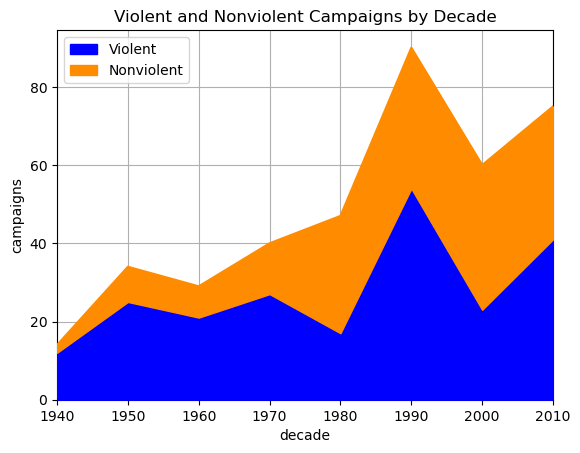

In [5]:
violent_by_dec = violent.groupby('Decade').size()
non_violent_by_dec = non_violent.groupby('Decade').size()

combined = pd.DataFrame({
    'Decade': violent_by_dec.index,
    'Violent': violent_by_dec.values,
    'Nonviolent': non_violent_by_dec.values
})

combined.set_index('Decade', inplace=True)
combined.plot(kind='area', stacked=True,zorder=3, color=['blue', 'darkorange'])

plt.title('Violent and Nonviolent Campaigns by Decade')
plt.xlabel('decade')
plt.ylabel('campaigns')

plt.margins(x=0)

plt.grid(True)

plt.show()

Nonviolent campaigns have always been more prevalent than violent ones, reaching their peak in the 1990s.

### Non violent campaigns and percentage of success per decade

We highlight the number of nonviolent campaigns per decade, along with the percentage of success for each decade

In [6]:
#find the successful non violent campaigns per decade and merge with all the non violent campaigns
success = non_violent[non_violent['SUCCESS'] == 1]
success_by_decade = success.groupby('Decade').agg({'SUCCESS':'count'}).reset_index()

non_violent_success_by_decade = success_by_decade.merge(non_violent_by_dec.reset_index(name='count'),on='Decade')
non_violent_success_by_decade['Success_Percentage'] = round(non_violent_success_by_decade['SUCCESS']/non_violent_success_by_decade['count'],2)

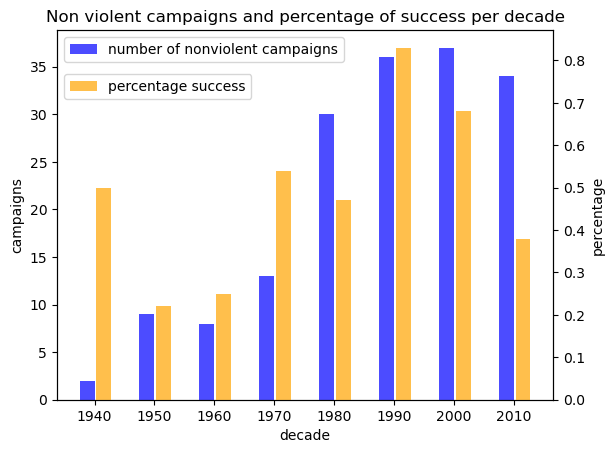

In [7]:
bar_width = 2.5
gap = 0.3
fig, ax1 = plt.subplots()

ax1.bar(non_violent_success_by_decade['Decade'] - bar_width / 2, non_violent_success_by_decade['count'], width=bar_width, color='b', alpha=0.7, label='number of nonviolent campaigns')
ax1.set_xlabel('decade')
ax1.set_ylabel('campaigns')
ax1.tick_params('y')
ax1.set_xticks(non_violent_success_by_decade['Decade'])

ax2 = ax1.twinx()
ax2.bar((non_violent_success_by_decade['Decade'] + bar_width / 2) + gap, non_violent_success_by_decade['Success_Percentage'], width=bar_width, color='orange', alpha=0.7, label='percentage success')
ax2.set_ylabel('percentage')
ax2.tick_params('y')

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

plt.title('Non violent campaigns and percentage of success per decade')
plt.show()

The 1990s and 2000s witnessed the highest frequency of nonviolent campaigns, alongside with the highest success rates.

## Success rate for violent and nonviolent campaigns by decade

We want to explore whether nonviolent campaigns have had a higher or lower probability of success compared to violent campaigns in the last decades.

In [8]:
violent_success = violent[violent['SUCCESS'] == 1]
violent_success_by_decade = violent_success.groupby('Decade').agg({'SUCCESS':'count'}).reset_index()

violent_success_by_decade = violent_success_by_decade.merge(violent_by_dec.reset_index(name='count'),on='Decade')
violent_success_by_decade['Success_Percentage_v'] = round(violent_success_by_decade['SUCCESS']/violent_success_by_decade['count'],2)

#merge both into one dataframe
violent_non_violent = violent_success_by_decade[['Decade','Success_Percentage_v']].merge(non_violent_success_by_decade[['Decade','Success_Percentage']],on='Decade')

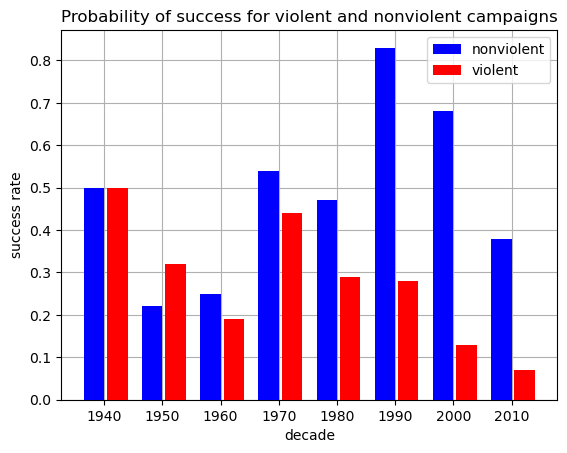

In [9]:
bar_width = 0.35
gap = 0.05
index = np.arange(len(violent_non_violent['Decade']))

plt.bar(index, violent_non_violent['Success_Percentage'], bar_width, color='blue', label='nonviolent',zorder=3)
plt.bar(index + bar_width + gap, violent_non_violent['Success_Percentage_v'], bar_width, color='red', label='violent',zorder=3)
plt.grid(axis='x', linestyle='-')
plt.grid(axis='y', linestyle='-')

plt.title('Probability of success for violent and nonviolent campaigns')
plt.xlabel('decade')
plt.ylabel('success rate')
plt.xticks(index + bar_width / 2, violent_non_violent['Decade'],zorder=0)
plt.legend()

plt.show()

We observe that in the period 1940-1960, both violent and non violent campaigns had almost equal probabilities of success. However, especially after 1980s, the probability of success of a violent campaign had been very low, and multiple times lower than the probability of a nonviolent one. 

## 2. Largest Resistance Campaigns, 1946-2014

We will plot all the resistance campaigns, for the period 1946-2014, with a percentage of participation at least 2.0%.

In [10]:
def color_based_on_result(row):
    if row['SUCCESS'] == 1:
        return 'black'
    elif row['LIMITED'] == 1:
        return 'gray'
    else:
        return 'red'

#ensure we get only events with participation >2% 
over_2_percent = campaigns[campaigns['PERCENTAGEPOPULARPARTICIPATION'] > 0.02].sort_values('PERCENTAGEPOPULARPARTICIPATION', ascending=True)

#convert result into string names
over_2_percent['color'] = over_2_percent.apply(color_based_on_result, axis=1)

over_2_percent['PERCENTAGEPOPULARPARTICIPATION'] = round(100*over_2_percent['PERCENTAGEPOPULARPARTICIPATION'],2)

#use only the necessary columns
over_2_percent = over_2_percent[['LOCATION','TARGET','color','PERCENTAGEPOPULARPARTICIPATION']]
over_2_percent = over_2_percent.sort_values('PERCENTAGEPOPULARPARTICIPATION')

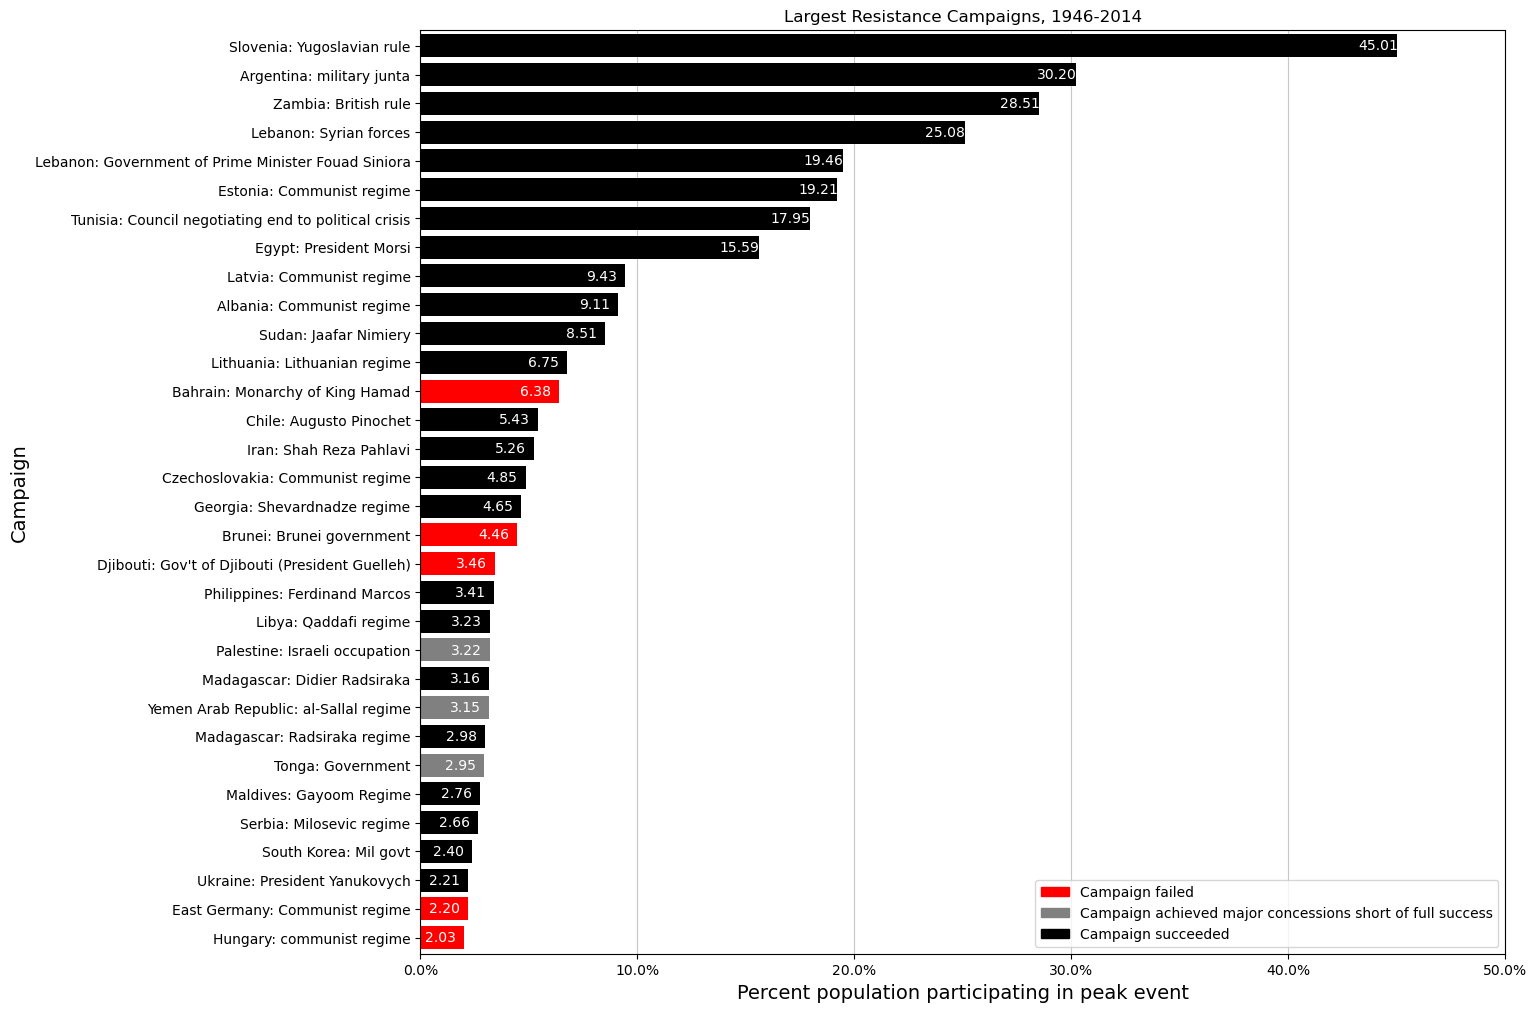

In [11]:
fig, ax = plt.subplots(figsize=(14, 12))

ax.set_title('Largest Resistance Campaigns, 1946-2014')
ax.grid(axis='x', linestyle='-', alpha=0.7)
ax.set_axisbelow(True)

bars = ax.barh(over_2_percent['LOCATION'] + ': ' + over_2_percent['TARGET'], over_2_percent['PERCENTAGEPOPULARPARTICIPATION'], color=over_2_percent['color'])

for bar, percentage in zip(bars, over_2_percent['PERCENTAGEPOPULARPARTICIPATION']):
    ax.text(bar.get_width() - 1.8, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}', ha='left', va='center',color='white')

ax.set_xlabel('Percent population participating in peak event',fontsize=14)
ax.set_ylabel('Campaign',fontsize=14)

legend_labels = {'Campaign failed' :'Red', 'Campaign achieved major concessions short of full success': 'Gray', 'Campaign succeeded': 'Black'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_labels.values()]
ax.legend(legend_handles, legend_labels.keys(), loc='lower right')

z =int(round(over_2_percent['PERCENTAGEPOPULARPARTICIPATION'].max(),-1))
ax.set_xticks(range(0, z+1, 10))
ax.set_xticklabels([f'{x:.1f}%' for x in range(0,z+1,10)])  #add the '%' on x axis

plt.margins(y=0.005)

plt.show()

## 3. The Effect of Participation on the Probability of Campaign Success

We assess the impact of participation on the probability of campaign success. To achieve that, we run a logistic regression with dependent variable the campaign success and independent variable the membership per capita, while also considering the size of the location's population (logged) at the end of the campaign.

From the documentation of [NAVCO 1.1](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YLLHEE), we find that the membership per capita is calculated as:


$$
\text{Membership per capita} = \frac{\text{lmembers}}{\text{lnpop}}
$$

Where:

- **lmembers**: Log of the Number of members in campaign at highest point (peak event)


- **lnpop**: Location’s population the year the campaign ends, logged

Also from the documentation of [NAVCO 1.2](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0UZOTX), on the dataset we have the variables:

- **Participation**: Number of participants observed actively confronting opponent at highest point (peak event).

- **Percentage Popular Participation**: Percent of target’s national population involved in peak event (participation /  population)

These 2 variables are sufficient to find the population, and then apply calculations to find the **membership per capita**, as indicated

In [12]:
#remove the campaigns on which the participation is unknown
campaigns = campaigns.dropna(subset='PARTICIPATION')

campaigns['POPULATION'] = (campaigns['PARTICIPATION'] / campaigns['PERCENTAGEPOPULARPARTICIPATION']).astype(int)

#convert to logs to calculate membership per capita as indicated in the documentation
campaigns['LOGGED_POPULATION'] = np.log(campaigns['POPULATION'])
campaigns['LOGGED_PARTICIPATION'] = np.log(campaigns['PARTICIPATION'])

campaigns['MEMBERSHIP_PER_CAPITA'] = campaigns['LOGGED_PARTICIPATION'] / campaigns['LOGGED_POPULATION']

In [13]:
logit_mod = logit("SUCCESS ~ LOGGED_POPULATION + MEMBERSHIP_PER_CAPITA",data=campaigns)

logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                SUCCESS   No. Observations:                  380
Model:                          Logit   Df Residuals:                      377
Method:                           MLE   Df Model:                            2
Date:                Sun, 26 May 2024   Pseudo R-squ.:                  0.1297
Time:                        14:01:58   Log-Likelihood:                -220.69
converged:                       True   LL-Null:                       -253.58
Covariance Type:            nonrobust   LLR p-value:                 5.189e-15
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.8142      1.496     -1.881      0.060      -5.746       0.

The results of the model confirm the strong positive relationship between the **membership per capita** and the 
**probability of success**. 

The coefficient 7.64 confirms that an increase in membership per capita is associated with a significant increase in the probability of success.

On the other hand, the variable of the **logged population**, without being combined with the participation, does not seem to be a significant factor to predict the outcome of a campaign. However, the p-value of the variable (0.059) is marginally non-significant.

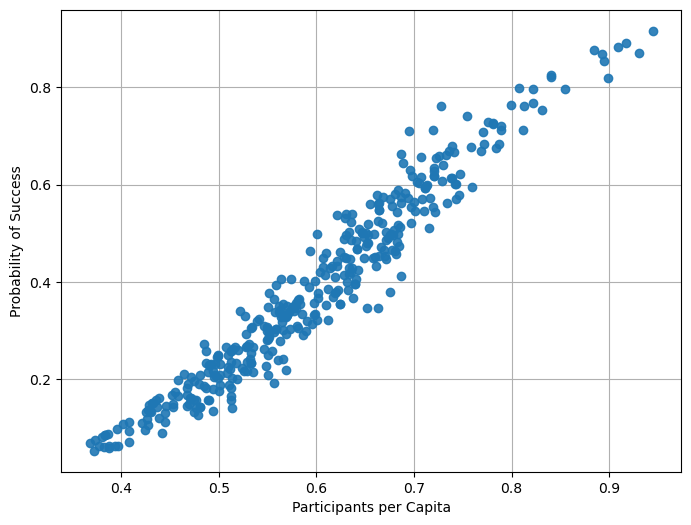

In [14]:
plt.figure(figsize=(8, 6))
plt.xlabel('Participants per Capita')
plt.ylabel('Probability of Success')
plt.scatter(campaigns['MEMBERSHIP_PER_CAPITA'],logit_res.predict(campaigns), alpha=0.9,zorder=3)
plt.grid()

plt.show()

With this plot, we observe the positive relationship between the membership per capita and the probability of success. As also found by the previous model, we see that the increase in the membership per capita variable, results in an increase to the probability of success

If we run the same model, but this time only with the **membership per capita** as the independent variable, the results are the following:

In [15]:
logit_mod2 = logit("SUCCESS ~ MEMBERSHIP_PER_CAPITA",data=campaigns)

logit_res2 = logit_mod2.fit()

print(logit_res2.summary())

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                SUCCESS   No. Observations:                  380
Model:                          Logit   Df Residuals:                      378
Method:                           MLE   Df Model:                            1
Date:                Sun, 26 May 2024   Pseudo R-squ.:                  0.1225
Time:                        14:01:59   Log-Likelihood:                -222.51
converged:                       True   LL-Null:                       -253.58
Covariance Type:            nonrobust   LLR p-value:                 3.204e-15
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.3469      0.709     -7.536      0.000      -6.737      -3.

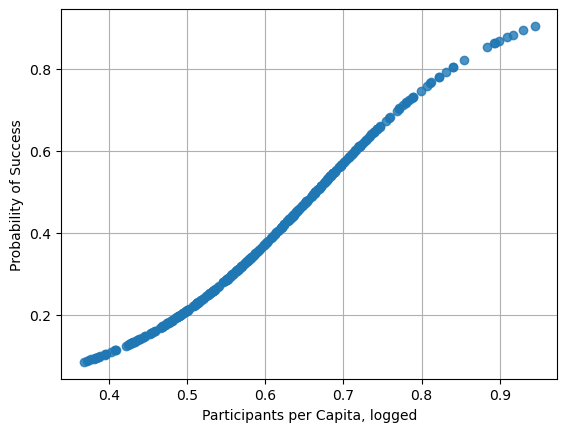

In [16]:
plt.xlabel('Participants per Capita, logged')
plt.ylabel('Probability of Success')

plt.scatter(campaigns['MEMBERSHIP_PER_CAPITA'],logit_res2.predict(campaigns), alpha=0.8,zorder=3)
plt.grid()

plt.show()

This plot is different from the previous, because with the only independent variable **MEMBERSHIP_PER_CAPITA** (coef = 8.0495), we can clearly see the significance of the variable in predicting the outcome of the campaign, and specifically the positive relationship to the probability of success

## 4. The Level of Participation Tipping Point


As mentioned in the beginning, the research of Chenoweth arrives to the famous conclusion of the 3.5% rule, which claims that ["no government has withstood a challenge of 3.5% of their population mobilized against it during a peak event"](https://www.hks.harvard.edu/sites/default/files/2024-05/Erica%20Chenoweth_2020-005.pdf)


To replicate the table found in the [discussion paper](https://www.hks.harvard.edu/sites/default/files/2024-05/Erica%20Chenoweth_2020-005.pdf) of Chenoweth, we will split the campaigns into distinct groups. The final group will specifically include only those campaigns with peak popular participation exceeding 3.5%. We will then observe and compare the success rates across these different groups.

In [17]:
#remove campaigns on which the number of population is unknown
campaigns = campaigns.dropna(subset='POPULATION')    

campaigns['PERCENTAGEPOPULARPARTICIPATION_PERCENT'] = 100 * campaigns['PERCENTAGEPOPULARPARTICIPATION']

#split the peak popular participation into bins
bin_edges = [0,0.0035, 0.015, 0.06, 0.25, 1, 3.5, float('inf')]
bin_labels = ['less than 0.0035%', '0.0035% - 0.015%', '0.015% - 0.06%', '0.06% - 0.25%', '0.25% - 1.0%', '1.0% - 3.5%', 'greater than 3.5%']

campaigns['POPULAR_PARTICIPATION_BUCKET'] = pd.cut(campaigns['PERCENTAGEPOPULARPARTICIPATION_PERCENT'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [18]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#count the occurences per each bucket where success = 1 
rule = campaigns.groupby('POPULAR_PARTICIPATION_BUCKET')['SUCCESS'].agg(['count', lambda x: (x == 1).sum()]).reset_index()
rule.columns = ['Peak Popular Participation (%)','Observations','Occurences']

rule['Success Rate'] = round(100*rule['Occurences']/rule['Observations'],2)
rule = rule.sort_values('Success Rate',ascending=False)

# add '%' format
rule['Success Rate'] = rule['Success Rate'].apply(lambda x: '{:.2f}%'.format(x))

rule = rule.drop(columns='Occurences')
rule

,Peak Popular Participation (%),Observations,Success Rate
6,greater than 3.5%,18,88.89%
5,1.0% - 3.5%,41,60.98%
4,0.25% - 1.0%,92,45.65%
3,0.06% - 0.25%,95,45.26%
2,0.015% - 0.06%,66,24.24%
1,0.0035% - 0.015%,44,9.09%
0,less than 0.0035%,24,4.17%


On the table above, we obeserve that the Success Rate increases along with the percentage of Peak Popular Participation. 

However, the Success Rate is not 100% with participation over 3.5%, so we can find the cases that the campaign was unsuccessful

In [19]:
unsuccesful3_5 = campaigns[(campaigns['PERCENTAGEPOPULARPARTICIPATION'] > 0.035) & (campaigns['SUCCESS'] == 0)]

print('Unsuccessful campaigns:')
for index,row in unsuccesful3_5.iterrows():
    print(f"{row['CAMPAIGN']}, {row['LOCATION']}, {row['EYEAR']}")

Unsuccessful campaigns:
Anti-King Hamad Campaign, Bahrain, 2014
Brunei Revolt, Brunei, 1962


For the case of Brunei, the country had a population of 90.000, which makes the case non representative, [per Chenoweth](https://www.hks.harvard.edu/sites/default/files/2024-05/Erica%20Chenoweth_2020-005.pdf).

In [20]:
print(f'Population of {unsuccesful3_5["LOCATION"].iloc[0]}: {unsuccesful3_5["POPULATION"].iloc[0]}')
print(f'Population of {unsuccesful3_5["LOCATION"].iloc[1]}: {unsuccesful3_5["POPULATION"].iloc[1]}')

Population of Bahrain: 1566993
Population of Brunei: 89603


Also, it appears that in Brunei the target received over military aid from the British government to fight the campaign, and Brunei's military stayed loyal to the regime during the assault.

From documentation of [NAVCO 1.2](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0UZOTX): 

STATESUP: "Binary variable indicates whether campaign received overt military or economic aid from an 
outside another state to fight against the target."

In [21]:
if unsuccesful3_5['STATESUP'].iloc[1] == 1: 
    print(f'{unsuccesful3_5["LOCATION"].iloc[1]} received military aid')

Brunei received military aid


Similar case is Bahrain, on which the government is strongly backed up by Saudi Arabia and the United States.

As Chenoweth [states](https://www.hks.harvard.edu/sites/default/files/2024-05/Erica%20Chenoweth_2020-005.pdf):

<<The 3.5% rule may not apply in Brunei and Bahrain or countries like them—small monarchies with access to overwhelming
foreign military reinforcement. But these are rare and unique national profles, and—for now—the rule appears to persist
in all other cases.>>

### Confidence intervals for 99% probability of success

We can statistically derive Chenoweth's 3.5% rule by determining the population percentage that represents the tipping point for campaign success with a 99% probability. In the last scatter plot, we observe that the curve generated by the model do not intersect with the line that represents 99% probability of success. This suggests that there is no point where the predicted probability of success reaches exactly 99%.

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


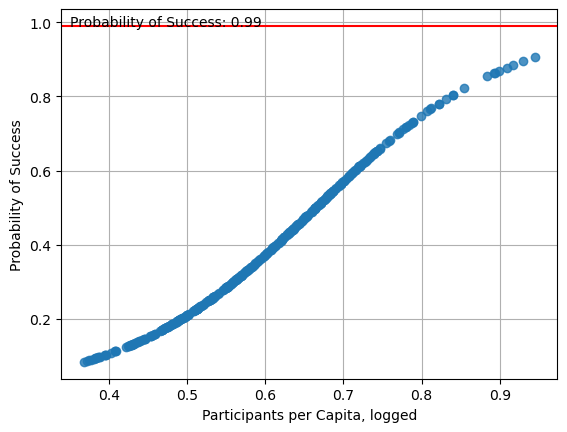

In [22]:
logit_mod2 = logit("SUCCESS ~ MEMBERSHIP_PER_CAPITA",data=campaigns)

logit_res2 = logit_mod2.fit()

plt.xlabel('Participants per Capita, logged')
plt.ylabel('Probability of Success')

plt.scatter(campaigns['MEMBERSHIP_PER_CAPITA'],logit_res2.predict(campaigns), alpha=0.8,zorder=3)

#add the red line y = 0.99 (probability of success)
plt.axhline(y=0.99, color='red', linestyle='-')
plt.text(0.35, 0.99, 'Probability of Success: 0.99', color='black')

plt.grid()
plt.show()

For this reason, we should include a confidence interval around the predicted probabilities, and then find the first point that intersects with the red line that represents 99% probability of success. 

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


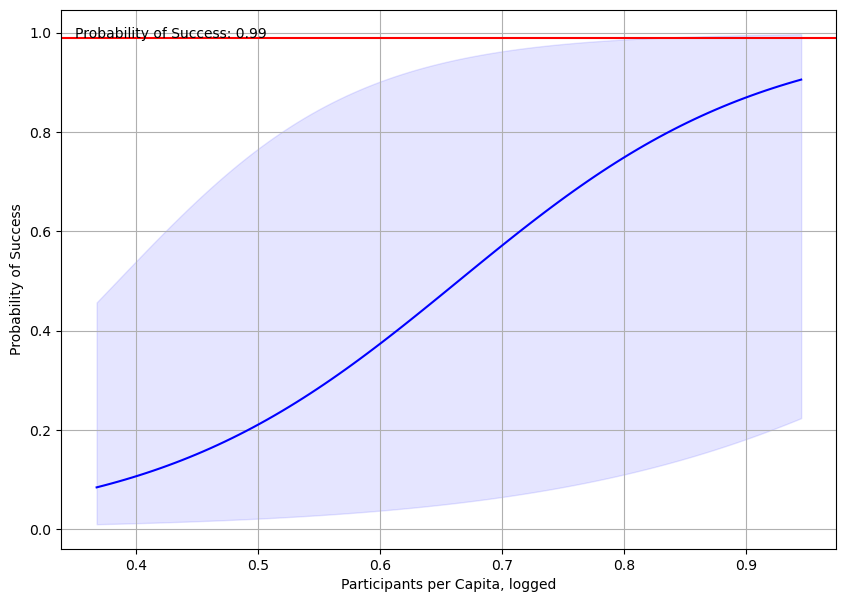

In [23]:
from scipy.special import expit  # Logistic sigmoid function

logit_model = sm.Logit(campaigns['SUCCESS'], sm.add_constant(campaigns['MEMBERSHIP_PER_CAPITA'])).fit()

conf = logit_model.conf_int()

#range of prediction
x_vals = np.linspace(campaigns['MEMBERSHIP_PER_CAPITA'].min(), campaigns['MEMBERSHIP_PER_CAPITA'].max(), 100)
X = sm.add_constant(x_vals)

#predicted probabilities using the model
pred_probs = logit_model.predict(X)

# the lower and upper bounds of the confidence intervals 
pred_ci_low = expit(np.dot(X, conf.iloc[:, 0]))
pred_ci_high = expit(np.dot(X, conf.iloc[:, 1]))

plt.figure(figsize=(10, 7))
plt.xlabel('Participants per Capita, logged')
plt.ylabel('Probability of Success')

plt.plot(x_vals, pred_probs, color='blue')
plt.fill_between(x_vals, pred_ci_low, pred_ci_high, color='blue', alpha=0.1)

#add the red line y = 0.99 (probability of success)
plt.axhline(y=0.99, color='red', linestyle='-')
plt.text(0.35, 0.99, 'Probability of Success: 0.99', color='black')

plt.grid()
plt.show()

In [24]:
intersection_index = np.argmax(pred_ci_high >= 0.99)
intersection_x = x_vals[intersection_index]
print(f'The point where the upper confidence interval intersects with the red line that corresponds to 99% success probability is {round(intersection_x,1)}')

The point where the upper confidence interval intersects with the red line that corresponds to 99% success probability is 0.8


With this plot, we observe that including the confidence interval, the upper bound intersects with the line y = 0.99 (probability of success 99%), on x-axis in the point 0.8. So with 0.8 membership per capita, there is an indication of a **99%** probability of success in the campaign

To find the percentage of population, we will get all the data we have with membership per capita >= 0.8

In [25]:
success_99 = campaigns[campaigns['MEMBERSHIP_PER_CAPITA'] >= 0.8]
print(f'Out of all the campaigns that had membership per capita above {round(intersection_x,1)}, the campaign with the least percentage of participation had {round(success_99["PERCENTAGEPOPULARPARTICIPATION_PERCENT"].min(),2)}%')

Out of all the campaigns that had membership per capita above 0.8, the campaign with the least percentage of participation had 3.41%


This percentage is closely aligning with Chenoweth's rule.

## 5. Nonviolent Resistance and Target Regime Type

We can assess the significance of nonviolent resistance when controlling the type of the regime. To achieve that, we can run a logistic regression of success on the nonviolence indicator, considering the log of participation, the location's logged population, along with the Polity V score of the campaign target. 

Definition of **Polity V** score as [documented](https://www.systemicpeace.org/polityproject.html): 

"The Polity Score captures this regime authority spectrum on a 21-pont scale ranging from -10 (hereditary monarchy) to +10 (consolidated democracy). The Polity scores can also be converted into regime categories in a suggested three part categorization of "autocracies" (-10 to -6), "anocracies" (-5 to +5 and three special values: -66, -77 and -88), and "democracies" (+6 to +10)."

In [27]:
polity = pd.read_excel('data/p5v2018.xls')

In [28]:
print('Polity range:', polity['polity'].min(), polity['polity'].max())
print('Polity2 range:', polity['polity2'].min(), polity['polity2'].max())

Polity range: -88 10
Polity2 range: -10.0 10.0


In [29]:
#We will use the polity2 column, that has modified all the values in the range of [-10,10]

# rename columns to merge with campaigns dataframe
polity = polity.rename(columns={'country': 'LOCATION','polity2':'POLITY2', 'polity': 'POLITY','year':'EYEAR'})

In [30]:
campaigns_polity = campaigns.merge(polity[['LOCATION','POLITY','POLITY2','EYEAR']],on=['LOCATION','EYEAR'])

Optimization terminated successfully.
         Current function value: 0.571361
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                SUCCESS   No. Observations:                  134
Model:                          Logit   Df Residuals:                      130
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 May 2024   Pseudo R-squ.:                  0.1525
Time:                        14:02:10   Log-Likelihood:                -76.562
converged:                       True   LL-Null:                       -90.343
Covariance Type:            nonrobust   LLR p-value:                 4.489e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8905      2.205     -0.404      0.686      -5.212       3.431

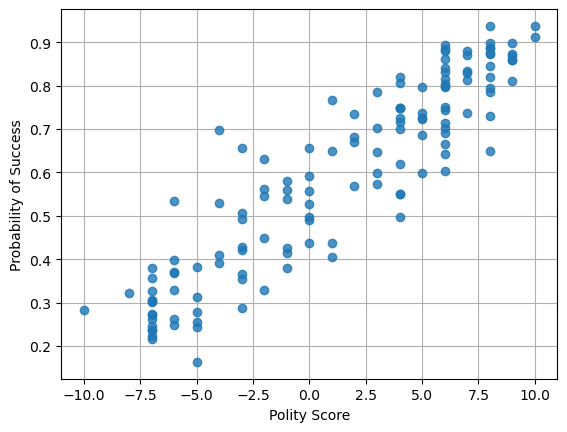

In [31]:
non_viol = campaigns_polity[campaigns_polity['NONVIOL'] == 1]

non_viol = non_viol.dropna(subset='POLITY2')
 
logit_model_polity = logit("SUCCESS ~ + LOGGED_PARTICIPATION + LOGGED_POPULATION + POLITY2",data=non_viol).fit()

print(logit_model_polity.summary())

plt.xlabel('Polity Score')
plt.ylabel('Probability of Success')

plt.scatter(non_viol['POLITY2'], logit_model_polity.predict(non_viol), alpha=0.8,zorder=3)
plt.grid()

plt.show()

The coefficient of **Polity** (0.156) is positive and highly significant, suggesting that higher polity scores (indicating more democratic regimes) are associated with a higher probability of success for nonviolent campaigns.

Also, as described in previous model, the variable of **participation** (0.241) is the most significant factor and increases the probability of success for nonviolent campaigns, while the log of **population** does not have a significant impact on the probability of success in this model.

This plot indicates the positive correlation between the level of democracy in the target country and the likelihood of success for a non-violent campaign.